# 輸入全部(2020 M8 ~ 2021 M3)的資料

In [1]:
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.under_sampling import NearMiss

In [ ]:
Module=pd.read_csv("Module_all.csv").iloc[:,1:]

risk_db=pd.read_csv("risk_db_all.csv").iloc[:,1:]

array_repair=pd.read_csv("array_repair_all.csv").iloc[:,1:]

cell_repair=pd.read_csv("cell_repair_all.csv").iloc[:,1:]

cell_test=pd.read_csv("cell_test_all.csv").iloc[:,1:]

DataSet=pd.read_csv("DataSet.csv").iloc[:,1:-3]

print('Array:',len(array_repair),'\nCell_test:',len(cell_test),'\nCell_repair:',len(cell_repair),'\nRisk:',len(risk_db),'\nModule:',len(Module))

DEF
1.分割資料集:
split_lmb : 按比例分割資料成 訓練集 & 測試集 array_f ~ module_f : 各階段資料的前處理 Data_Sorted : 彙整合併 TypeOfBad : 列印測試集 BAD ID Train_Test : 分割 Bad_Type_def : 種類定義 Balance_Ratio(data,n=5) : 平衡率,n=小數點後位數 Bad_Type_by_Time(data) : 全部資料 BAD 順序 (按月)
2.訓練集分析,測試集理想曲線:
Corner/Kind/Remove_SD/Corner_Blend/Dictionary_Build/AUC/Idea_PR
3.OS:
Distance/getIndexes/ID_Given_Distance/perm/major_ratio/n_major_single_corner/cumu_conbine/Border/Self_Expand
4.US:
US_RUS/US_NM/US_UHT / OS/ OS_DF
5.Y值連續化

In [10]:
''' --------------------------------------   1. 分割資料集  -------------------------------------- '''

def split_imb(Level,size=0.2,r=0):

    level_set=Level.GB.unique() #1,0
    level_count=len(Level.GB.unique()) #2

    global X_train,X_validate,Y_train,Y_validate
    
    X_train=pd.DataFrame()
    X_test=pd.DataFrame()
    Y_train=pd.DataFrame()
    Y_test=pd.DataFrame()
    
    for i in range(level_count):
        L=Level[Level.GB==level_set[i]]
        Y=L.GB.values
        X=L.iloc[:,:-1].values
    
        x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=size,random_state=r)

        X_train=pd.concat([X_train,pd.DataFrame(x_train)])
        X_test=pd.concat([X_test,pd.DataFrame(x_test)])
        Y_train=pd.concat([Y_train,pd.DataFrame(y_train)])
        Y_test=pd.concat([Y_test,pd.DataFrame(y_test)])
        
    X_train=X_train.values
    Y_train=Y_train.values.flatten()
    X_test=X_test.values
    X_validate=X_test
    Y_test=Y_test.values.flatten()
    Y_validate=Y_test
    
    return X_train,Y_train,X_validate,Y_validate

def array_f(array_repair):

    ## reorder cols
    cols = array_repair.columns.tolist()
    cols = cols[3:4]+cols[1:3]
    array_repair=array_repair[cols]

    ## dummy tool & dft (同一個 ID 中只要有用到就是1 沒有就是0)
    array_repair_dummy=pd.get_dummies(array_repair,columns=['tool_id','dft_mode'])
    
    array_repair_dummy=array_repair_dummy.groupby(['id']).max().reset_index()
    
    return array_repair_dummy

def cell_test_f(cell_test):
    
    ## delete the tft_chip_id and reorder
    cols = cell_test.columns.tolist()
    cols = cols[-1:]+cols[1:3]
    cell_test=cell_test[cols]

    ## dummy
    cell_test_dummy=pd.get_dummies(cell_test,columns=['test_user','grade'])

    cell_test_dummy=cell_test_dummy.groupby(['id']).max().reset_index()
    
    return cell_test_dummy

def cell_repair_f(cell_repair):
    
    # delete the tft_chip_id and reorder
    cell_repair=cell_repair.iloc[:,2:]
    cols = cell_repair.columns.tolist()
    cols = cols[-1:]+cols[0:-2]
    cell_repair=cell_repair[cols]


    ## dummy
    cell_repair_dummy=pd.get_dummies(cell_repair,columns=['eqp_id','test_defect_code_desc'])

    cell_repair_dummy=cell_repair_dummy.groupby(['id']).max().reset_index()

    return cell_repair_dummy

def risk_db_f(risk_db):
    
    cols = risk_db.columns.tolist()
    cols = cols[-1:]+cols[-2:-1]+cols[0:2]
    risk_db=risk_db[cols]


    ## dummy
    risk_db['Stage_Event'] = risk_db['process_stage'].str.cat(risk_db[['event_name']], sep=' - ')
    risk_db=risk_db[['id','Stage_Event']]
    risk_dummy=pd.get_dummies(risk_db,columns=['Stage_Event'])

    risk_dummy=risk_dummy.groupby(['id']).max().reset_index()
    
    return risk_dummy

def module_f(Module):
    
    cols = Module.columns.tolist()
    cols = cols[2:5]+cols[1:2]
    Module=Module[cols]

    ## dummy
    Module_dummy=pd.get_dummies(Module,columns=['model_no'])

    Module_dummy=Module_dummy.groupby(['id']).max().reset_index()

    ## reorder
    cols = Module_dummy.columns.tolist()
    cols = cols[3:]+cols[0:3]
    Module_dummy=Module_dummy[cols]
    Module_dummy
   
    return Module_dummy

def DataSet_Sorted(array_repair,cell_test,cell_repair,risk_db,Module):
    
    #global DataSet
    pd.options.mode.chained_assignment = None
    
    cell_test_dummy=cell_test_f(cell_test)
    cell_repair_dummy=cell_repair_f(cell_repair)
    risk_dummy=risk_db_f(risk_db)
    array_repair_dummy=array_f(array_repair)
    Module_dummy=module_f(Module)


    CTC=cell_test_dummy.merge(cell_repair_dummy,how='outer',on='id')
    CTCR=CTC.merge(risk_dummy,how='outer',on='id')
    CTCRA=CTCR.merge(array_repair_dummy,how='inner',on='id')
    DataSet=CTCRA.merge(Module_dummy,how='inner',on='id').fillna(0)
    
    cols=DataSet.columns[DataSet.nunique() == 1]

    DataSet=DataSet.drop(cols,axis=1)
    
    return DataSet

def TypeOfBad(df,sorting=1):
    
    global Bad
    
    TestingSet_Bad=df[df.GB==1]
    Bad=[]
    for j in range(len(TestingSet_Bad)):
        Key=TestingSet_Bad.iloc[:,1:-1].apply(lambda x:'_'.join(x.astype(str)),axis=1)
        Bad=np.append(Bad,Bad_Types[Key.values[j]])
        if sorting==1:
            Bad.sort()

    #print('Types of Bad :\n',Bad[:5],"\n",Bad[5:],'\n')
    print('Types of Bad :\n',Bad,'\n')

def Train_Test(D,y_1=2020,m_1=11,d_1=15,y_2=2020,m_2=11,d_2=30):
    
    
    data=D.copy()
    
    date=data['shift_date'].str.split("/",expand=True)
    date=date.astype(int)
    date.columns=['month','day','year']
    DataSet_split=pd.concat([data,date],axis=1)
    DataSet_split=DataSet_split.drop('shift_date',axis=1)
    DataSet_split=DataSet_split.sort_values(by=['year','month','day'])
    DataSet_split=DataSet_split.reset_index(drop=True)
    count_1=DataSet_split[(DataSet_split.year==y_1)&(DataSet_split.month==m_1)&(DataSet_split.day<=d_1)].tail(1).index.item()
    count_2=DataSet_split[(DataSet_split.year==y_2)&(DataSet_split.month==m_2)&(DataSet_split.day<=d_2)].tail(1).index.item()
    TrainingSet_0=DataSet_split.iloc[:count_1+1,:].iloc[:,:-3]
    TestingSet_0=DataSet_split.iloc[count_1+1:count_2+1,:].iloc[:,:-3]
    
    
    return TrainingSet_0,TestingSet_0,DataSet_split

def Bad_Type_def(DataSet_All):
    
    Data=DataSet_All.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    Data['GB_mean'] =Data.groupby('cb')['GB'].transform('mean')
    Data['GB_count'] =Data.groupby('cb')['GB'].transform('count')
    Data['B_count']=Data.groupby('cb')['GB'].transform('sum')
    All_Bad=Data[Data.GB==1]
    print('number of Bad:',len(All_Bad))
    All_Bad=All_Bad.sort_values(['B_count','GB_mean'],ascending=[False,False])
    Bad_Types=All_Bad.drop_duplicates(subset='cb')
    Bad_Types=Bad_Types[['cb','GB_mean','B_count']].reset_index(drop=True)
    print('types of Bad:',len(Bad_Types),'\n')
    return Bad_Types

def Balance_Ratio(data,n=5):
    
    r=len(data[data.GB==1])/len(data[data.GB==0])
    r=np.around(r,decimals=n)
    
    return r

def Bad_Type_by_Time(data):
    ## 各月份的BAD ID
    TimeSeries=data.sort_values(['year','month','day'])
    j=0
    for i in TimeSeries.month.unique():
        #j=j+1
        #print('Month',j,':\n')
        print('Month',i,':\n')
        TS=TimeSeries[TimeSeries.month==i].iloc[:,:-3]
        TypeOfBad(TS,sorting=0)
        
''' --------------------------------------   2. 訓練集分析  -------------------------------------- '''
        
def Corner(D):
    
    Data=D.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    Data['GB_mean'] =Data.groupby('cb')['GB'].transform('mean')
    Data['GB_count'] =Data.groupby('cb')['GB'].transform('count')
    Corner_overlap=Data.copy()
    
    return Corner_overlap

def Kind(Data):
    Kinds_0=Data[Data.GB_mean==0].sort_values('GB_count')
    Kinds_1=Data[Data.GB==1].sort_values('GB_count')
    Kinds=pd.concat([Kinds_1,Kinds_0])
    Kinds_after_duplicate=Kinds.drop_duplicates(subset=['cb']).reset_index(drop=True)
    return Kinds_after_duplicate

## Remove Small Disjuncts of GB=0
## 移除 OUTLIERS / 重疊數量(發生次數)較少的角點資料移除
def Remove_SD(Data,count=1):
    count=count
    RSD=pd.concat([Data[Data.GB==1],Data[(Data.GB==0)&(Data.GB_count>count)]])
    return RSD

## 將重疊的部分比例較高者  都視為 bad (GB=1)
def Corner_Blend(Data,ratio=0.002):
    D_1=Data[(Data.GB_mean<=1)&(Data.GB_mean>=ratio)].sort_values('GB_count')
    D_1[['GB']]=1
    D_2=Data[(Data.GB_mean<ratio)].sort_values('GB_count')
    D_2[['GB']]=0
    Training_new=pd.concat([D_1,D_2]).iloc[:,:-3]
    return Training_new

def Dictionary_Build(Data):
    
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    Data['GB_mean'] =Data.groupby('cb')['GB'].transform('mean')
    Data['GB_count'] =Data.groupby('cb')['GB'].transform('count')
    Corner_overlap=Data.copy()
    Kinds=Kind(Corner_overlap).copy()

    ## reorder cols
    cols = Kinds.columns.tolist()
    cols = cols[0:1]+cols[-4:]
    Dictionary=Kinds[cols]
    Dictionary['G_count']=0
    Dictionary=Dictionary.reset_index(drop=True)
    for i in range(len(Dictionary)):
        Dictionary['G_count'][i]=Dictionary.GB_count[i]-Dictionary.GB[i]
    Dictionary.to_csv('Dictionary.csv')
    return Dictionary

def AUC(x,y):
    area=0
    for i in range(1,len(x)):
        height=x[i]-x[i-1]
        area=area+height*(y[i-1]+y[i])/2
        
    return area

def Idea_PR(D):
    
    Data=D.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    Data['GB_mean'] =Data.groupby('cb')['GB'].transform('mean')
    Data['GB_count'] =Data.groupby('cb')['GB'].transform('count')

    Kinds_0=Data[Data.GB_mean==0].sort_values('GB_count')
    Kinds_1=Data[Data.GB==1].sort_values('GB_count')
    Kinds=pd.concat([Kinds_1,Kinds_0])
    print('num of Bad (test)',len(Kinds_1))
    print('kind of Bad (test)',len(Kinds.drop_duplicates(subset=['cb']).reset_index(drop=True)))
    
    Test_Kinds=Kinds.drop_duplicates(subset=['cb']).reset_index(drop=True)
    Aging_amount=Test_Kinds[Test_Kinds.GB==1].GB_count.sum()
    Precision=np.cumsum(Test_Kinds[Test_Kinds.GB==1].GB)/np.cumsum(Test_Kinds[Test_Kinds.GB==1].GB_count)
    Recall=np.cumsum(Test_Kinds[Test_Kinds.GB==1].GB)/Test_Kinds[Test_Kinds.GB==1].GB.sum()
    area=AUC(Recall.values,Precision.values)
    ar=Aging_amount/len(Data)
    fig = plt.figure()
    ax = plt.axes()
    plt.title('AUC OF M2M3 : %.3f \n\n Optimum_Aging_rate %.3f'%(area,ar))
    ax.plot(Recall,Precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
''' --------------------------------------   3. OS  -------------------------------------- '''
'''DEF 1'''
## Input : X+Y(146 cols)
## 計算距離 data1 及 data2 的距離
## Output : 資料點之間的距離

def Distance(data1,data2):
    
    data1_class=data1.iloc[:,-1].values
    data2_class=data2.iloc[:,-1].values
    data1=data1.iloc[:,:-1].values
    data2=data2.iloc[:,:-1].values
    data1_num=len(data1)
    data2_num=len(data2)

    
    df=pd.DataFrame()
    for i in range(data1_num):
        
        hamming_set=[]
        
        for j in range(data2_num):
            
            hamming= abs(data1[i]-data2[j]).sum()
            
            hamming_set=np.append(hamming_set,hamming)

        hamming_set=pd.DataFrame(hamming_set).T
        df=pd.concat([df,hamming_set])
        
    df=df.reset_index().iloc[:,1:]
    return df

'''DEF 2'''
## 給定 df 和 value 找出其 row 和 col

def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

'''DEF 3-1'''
## Input : X+Y(level)
#給定一個 資料集 和 值 後, 找出相對應的位置

def ID_Given_Distance(data1,d):
    D_Matrix=Distance(data1,data1)
    D_Matrix=D_Matrix.where(np.triu(np.ones(D_Matrix.shape)).astype(np.bool))
    combine=getIndexes(D_Matrix, d)
    return combine

'''DEF 3-2'''
## Input : X+Y(level)
#給定一個 資料集 和 值 後, 找出相對應的位置

def ID_Given_Distance_2(data1,data2,d):
    D_Matrix=Distance(data1,data2)
    ##數量不同 無法使用上三角
    D_Matrix=D_Matrix.where(np.triu(np.ones(D_Matrix.shape)).astype(np.bool))
    combine=getIndexes(D_Matrix, d)
    return combine


'''DEF 4'''
# 2個以上不同 的排列組合

def perm(cols):
    
    from itertools import permutations

    s=set()
    num=cols-1
    for i in range(num):
    
        TF_list=[True]*(cols-1-i)+[False]*(i+1)
        s_new=set(list(itertools. permutations(TF_list)))
        s=s|s_new
    
    return list(s) 
   

'''DEF 5'''
def major_ratio(df):
    
    df_new=df.copy().astype(float)
    df_new['cb'] = df_new[df_new.columns].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    
    count=0
    for i in range(len(df)):
        Match=df_new.cb[i] in CB_0.keys()
        if Match==True:
            count=count+1
    
    ratio=count/len(df)
    return ratio    

'''DEF 6'''
## 如果角點中已經重疊了大於 num 數量的 major 將移除
def n_major_single_corner(s_df,num):
    
    n=list(np.arange(len(s_df)))
    
    df_new=s_df.copy().astype(float)
    df_new['cb'] = df_new[df_new.columns].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    
    for i in range(len(s_df)):
        Match=df_new.cb[i] in CB_0.keys()
        if Match==True:
            Major_num=CB_0[df_new.cb[i]]
            if Major_num>num:
                n.remove(i)
                
    s_df_new=s_df.loc[n].copy()
    return s_df_new

'''DEF 7'''
#找到各組間隔為 rank 的座標
def cumu_conbine(rank):
    
    data1=data[data.level==1]
    data2=data[data.level==0]
    combine=[]
    
    for i in range(rank):
        combine=combine+ID_Given_Distance_2(data1,data2,i+1)
        
    return combine

'''Main Function 1'''
def Border(data,Near_Minor=3,Major_Ratio_max=0.5,n_major_corner=20):
    
    data1=data[data.level==1]
    data2=data[data.level==0]
    d=data.iloc[:,:-1].copy()
    training_df=pd.DataFrame()
    
    for a in range(2,Near_Minor+1):

        combine=ID_Given_Distance(data1,a)

        smote_df=pd.DataFrame()
        
        if len(combine)!=0:
            
        
            for b in range(len(combine)):

                ##選定一組數字,一個當中心點
                a_pair=combine[b]
                point_0=a_pair[0]
                point_1=a_pair[1]

                # d_smote 的初始值和中心點一樣
                d_smote=d.loc[point_0].copy()

                # 找出有差異處的 cols
                d_X=d.loc[point_0]-d.loc[point_1]
                cols=d_X[d_X!=0].index

                ## L為距離 2 的點之間的排列組合
                L=perm(len(cols))

                '''創造DATA_SMOTE(給定中心點:d_smote 和 L)'''
                s_df=pd.DataFrame()

                for i in range(len(L)):

                    cb=L[i]
                    s=pd.DataFrame([d_smote]).copy()

                    for j in range(len(cb)):
                        if cb[j]==True:

                            s[cols[j]]=1-d_smote[cols[j]]
                        elif cb[j]==False:

                            s[cols[j]]=d_smote[cols[j]]

                    s_df=pd.concat([s_df,s])
                s_df=s_df.reset_index(drop=True)

                '''s_df為某兩點之間的生成資料'''

                #print(major_ratio(s_df))
                '''檢查此生成的資料中有多少比例是Majority'''
                if major_ratio(s_df)<Major_Ratio_max:

                    #接著檢查單角點 majority ratio
                    s_df_new=n_major_single_corner(s_df,n_major_corner)

                    s_df_new['GB']=1
                    smote_df=pd.concat([smote_df,s_df_new])
                    
                    
        #距離 r 間所SMOTE出來的資料
        smote_df=smote_df.drop_duplicates().reset_index(drop=True)
        
    #結合各個距離所SMOTE出來的資料
    training_df=pd.concat([training_df,smote_df])
    training_df=training_df.drop_duplicates().reset_index(drop=True)
    return training_df

'''Main Function 2'''
def Self_Expand(data,Near_Major=1,expand_num=5):
    
    data1=data[data.level==1]
    data2=data[data.level==0]
    
    Bad_count=len(data1)
    #training_df=pd.DataFrame()
    
    import random
    
    random.seed(0)
    
    combine=cumu_conbine(Near_Major)

    combine.sort()
    
    num=expand_num
    
    s_df=pd.DataFrame()
    smote_df=pd.DataFrame()
    
    for i in range(Bad_count):
        center=i
        near=[]
        d_smote=data1.iloc[:,:-1].loc[i].copy()
        c=[]
        for i in range(len(combine)):
            if combine[i][0]==center:
                near=np.append(near,combine[i][1])
                
                for i in range(len(near)):
                    n=min(near[i],len(data2)-1)
                    d_X=data1.iloc[:,:-1].loc[center]-data2.iloc[:,:-1].reset_index(drop=True).loc[n]
                    cols=d_X[d_X!=0].index
                    
                    c=np.append(c,cols)
                    ## 每兩點(同一個center , 不同的 near)之間中 ，其值有所不同的col欄位 : c , 並累積
    
                    
        L=list(set(d_smote.index)-set(c))
        ## 對於每一個center來說 , 剩下可以SMOTE的欄位 : L
        
        ## 隨機選擇欄位
        s_df=pd.DataFrame()
        
        ## 如果self expand的數量超過可以expand的 , 會將全部可以的 Rank 1 資料顯示
        if len(L)> num:
            Random_L=random.sample(L,num)
            for k in range(num):
                s=pd.DataFrame([d_smote]).copy()
                s[Random_L[k]]=1-s[Random_L[k]]
                s_df=pd.concat([s_df,s])
                ## 蒐集剩下欄位中 , 隨機SMOTE的資料
        else : 
            Random_L=random.sample(L,len(L))
            for k in range(len(L)):
                s=pd.DataFrame([d_smote]).copy()
                s[Random_L[k]]=1-s[Random_L[k]]
                s_df=pd.concat([s_df,s])
                ## 蒐集剩下欄位中 , 隨機SMOTE的資料
            

        
        #for k in range(num):
            #s=pd.DataFrame([d_smote]).copy()
            #s[Random_L[k]]=1-s[Random_L[k]]
            #s_df=pd.concat([s_df,s])
            ## 蒐集剩下欄位中 , 隨機SMOTE的資料
                    
        s_df=s_df.reset_index(drop=True)
        s_df['GB']=1
                
        smote_df=pd.concat([smote_df,s_df])
    
    
    
    smote_df=smote_df.drop_duplicates()               
    return smote_df

''' --------------------------------------   4. US  -------------------------------------- '''

def US_RUS(X_train,y_train,r=0,b_ratio=0.1):
    
    
    
    rus = RandomUnderSampler(random_state=r,sampling_strategy=b_ratio)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    


    
    return X_train_res, y_train_res
    
def US_NM(X_train,y_train,r=0,b_ratio=0.1):
    

    
    nm1 = NearMiss(version=1,sampling_strategy=b_ratio)
    X_train_res, y_train_res = nm1.fit_resample(X_train, y_train)
    
 

    
    return X_train_res, y_train_res

def US_IHT(X_train,y_train,r=0,b_ratio=0.1,cv=5):
    

    
    iht = InstanceHardnessThreshold(sampling_strategy=b_ratio, random_state=r,cv=cv,estimator=LogisticRegression(solver='lbfgs', max_iter=200,multi_class='auto'))
    X_train_res, y_train_res = iht.fit_resample(X_train, y_train)
    


    
    return X_train_res, y_train_res

## 調整參數 (3,0.9,500) / (2,50)
def OS(D,p1,p2,p3,p4,p5):
    
    data=D.copy()
    SMOTE_1=Border(data,Near_Minor=p1,Major_Ratio_max=p2,n_major_corner=p3)
    SMOTE_2=Self_Expand(data,Near_Major=p4,expand_num=p5)
    training_df=pd.concat([SMOTE_1,SMOTE_2]).drop_duplicates()


    return training_df


def OS_DF(D,p1,p2,p3,p4,p5):
    
    Data=D.copy()
    training_DF_1=Data.copy()
    Data['cb'] = Data[Data.columns[:-1]].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    Data['GB_mean'] =Data.groupby('cb')['GB'].transform('mean')
    Data['GB_count'] =Data.groupby('cb')['GB'].transform('count')
    Corner_overlap=Data.copy()

    Kinds=Kind(Corner_overlap).copy()
    Kinds.rename({'GB':'level'},axis=1,inplace=True)
    data=Kinds.iloc[:,:-3]

    training_DF_2=OS(data,p1,p2,p3,p4,p5)
    training_DF=pd.concat([training_DF_1,training_DF_2])
    return training_DF


''' --------------------------------------   5. Y值連續化 -------------------------------------- '''

'''透過每個 Good 和 鄰近 NG 的距離來求新的 level，以利 S4_AdaRegressor 等會使用到回歸的分類器'''

## 連續變數可以使用
def level_set_cont(D_0,D_1):
    
    D_matrix_T=Distance(D_0,D_1)

    Score=[]
    boundary=4
    for i in range(len(D_matrix_T)):
        Near=D_matrix_T.loc[i][D_matrix_T.loc[i].values<boundary].reset_index(drop=True)
        count=len(Near)
        for i in range(count):
            Near[i]=Near[i]*(boundary-Near[i])
        score=Near.sum()
        Score=np.append(Score,score)
    for i in range(len(D_matrix_T)):
        
        s=(Score[i]-Score.min())/(Score.max()-Score.min())
        ## 設定Level範圍
        Score[i]=s*0.95
        
    ## 新的 level 在 [0,1] 之間的分布
    
    plt.xlabel('Y-label')
    plt.ylabel('amount')
    plt.hist(pd.DataFrame(Score).sort_values(0).values,bins=18)
    plt.show()
    #plt.plot(pd.DataFrame(Score).sort_values(0).values)
    #plt.show()    
    return Score


def Distance(data1,data2):
    
    data1_class=data1.iloc[:,-1].values
    data2_class=data2.iloc[:,-1].values
    data1=data1.iloc[:,:-1].values
    data2=data2.iloc[:,:-1].values
    data1_num=len(data1)
    data2_num=len(data2)

    
    df=pd.DataFrame()
    for i in range(data1_num):
        
        hamming_set=[]
        
        for j in range(data2_num):
            
            hamming= abs(data1[i]-data2[j]).sum()
            
            hamming_set=np.append(hamming_set,hamming)

        hamming_set=pd.DataFrame(hamming_set).T
        df=pd.concat([df,hamming_set])
        
    df=df.reset_index().iloc[:,1:]
    return df

def S3_NewLevel(num_DataSetting):
    
    for i in range(num_DataSetting):
        start = time.time()
        j=i+1
        D=pd.read_csv("DataSetting_%s.csv" %j).iloc[:,1:]
        print('Training_%s' %j)
        
        DataSet=D.copy()
        Kind=K.copy()
        
        ## 跟原始 NG 點的距離
        D_1=Kind[Kind.GB==1].iloc[:,1:-3]

        ## 新資料的 Majority 
        D_0=DataSet[DataSet.GB==0]
        
        Score=level_set_cont(D_0,D_1)

        D_0['New_GB']=Score
        D_1=DataSet[DataSet.GB==1]
        D_1['New_GB']=1
        DataSetting_reg=pd.concat([D_1,D_0])

        ## 儲存至對應的 DataSetting
        DataSetting_reg.to_csv('DataSetting_%s_reg.csv' %j)
        end = time.time()
        print("執行時間：%f 秒" % (end - start))

def NewLevel_AB(D,K):
    
    Kind=K.copy()
    DS=D.copy()
    
    D_1=Kind[Kind.GB==1].iloc[:,1:-3]
    D_0=DS[DS.GB==0]

    Score=level_set_cont(D_0,D_1)

    D_0['New_GB']=Score
    D_1=DS[DS.GB==1]
    D_1['New_GB']=1
    DataSetting_reg=pd.concat([D_1,D_0])

    return DataSetting_reg

# 輸入訓練集的最後一天 & 測試集的最後一天

In [6]:
''' --------------------------------------   1. 分割資料集  -------------------------------------- '''
start = time.time()

DataSet=DataSet_Sorted(array_repair,cell_test,cell_repair,risk_db,Module)
print('Total Data:',len(DataSet),', BR:',Balance_Ratio(DataSet))
DataSet_All=DataSet.copy()
DataSet_All=DataSet_All.drop('shift_date',axis=1)


'''輸入訓練集的最後一天 & 測試集的最後一天'''
TrainingSet_0,TestingSet_0,DataSet_split=Train_Test(DataSet,y_1=2020,m_1=8,d_1=31,y_2=2020,m_2=9,d_2=30)
print('\nTrainingSet_0:',len(TrainingSet_0),', BR:',Balance_Ratio(TrainingSet_0),'\nTestingSet_0:',len(TestingSet_0),', BR:',Balance_Ratio(TestingSet_0),'\n')
Bad_Types=Bad_Type_def(DataSet_All)
Bad_Types.to_csv('Bad_Types.csv')
Bad_Types={Bad_Types.cb[i]:i for i in range (len(Bad_Types))}

#optional
Bad_Type_by_Time(DataSet_split)

print('\nTestingSet:')
TypeOfBad(TestingSet_0,sorting=1)

end = time.time()
print("\n執行時間：%f 秒" % (end - start))

DataSet=pd.concat([TrainingSet_0,TestingSet_0])
DataSet.to_csv('DataSet.csv')
TrainingSet_0.to_csv('TrainingSet_0.csv')
TestingSet_0.to_csv('TestingSet_0.csv')

Total Data: 136298 , BR: 0.00049

TrainingSet_0: 15646 , BR: 0.00032 
TestingSet_0: 14203 , BR: 0.00063 

number of Bad: 67
types of Bad: 62 

Month 8 :

Types of Bad :
 [29. 12. 50. 35. 44.] 

Month 9 :

Types of Bad :
 [ 0. 14. 60. 16. 20. 30. 13. 47.  8.] 

Month 10 :

Types of Bad :
 [ 0. 18.  0. 54. 61. 34. 51. 59. 19. 41. 43.] 

Month 11 :

Types of Bad :
 [ 1. 32. 24. 31. 37. 56. 52. 26.] 

Month 12 :

Types of Bad :
 [25. 36. 28. 27. 38. 58.  1.  3. 57. 55.  3.] 

Month 1 :

Types of Bad :
 [21. 46.  9. 10. 53.] 

Month 2 :

Types of Bad :
 [ 4. 39. 17. 11.  5. 48.] 

Month 3 :

Types of Bad :
 [49. 40. 15.  6. 45. 33. 42. 22. 23.  2.  2.  7.] 


TestingSet:
Types of Bad :
 [ 0.  8. 13. 14. 16. 20. 30. 47. 60.] 


執行時間：31.287152 秒


# 輸入要移除的重疊度數量 EX : default=1 (remove single)

# 輸入重疊處Bad的比率 大於此比率則會全部轉換成Bad 反之則全部轉換成OK

Number of Kinds: 1368
After RS and OT : 14829 , BR: 0.02016
num of Bad (test) 9
1345


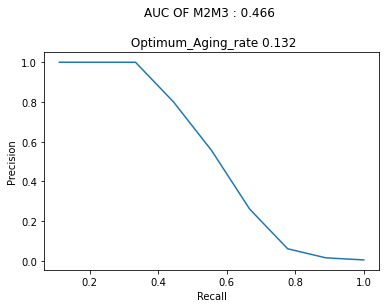

In [9]:
''' --------------------------------------   2. 訓練集分析  -------------------------------------- '''
Corner_overlap=Corner(TrainingSet_0)
Dictionary=Dictionary_Build(DataSet)
Dictionary.to_csv('Dictionary.csv')
Kinds=Kind(Corner_overlap).copy()
Kinds.to_csv('Kinds.csv')
print('Number of Kinds:',len(Kinds))

'''輸入要移除的重疊度數量 EX : default=1 (remove single)'''
US_1=Remove_SD(Corner_overlap,1)
US_1.iloc[:,1:-3]

'''輸入重疊處Bad的比率 大於此比率則會全部轉換成Bad 反之則全部轉換成OK'''
Training_new=Corner_Blend(US_1,1/500)
Training_new.to_csv('TrainingSet_new.csv')
print('After RS and OT :',len(Training_new),', BR:',Balance_Ratio(Training_new,n=5))
Idea_PR(TestingSet_0)

# OS_B (Border) , OS_S (Self expand) & 最終TrainingSet控制比例default=0.3

In [11]:
Near_m=3
MR_max=0.9
n_major=500
Near_M=2
expand=5
Ratio_Control=0.3

In [15]:
''' --------------------------------------   3. OS  -------------------------------------- '''
Kinds=pd.read_csv('Kinds.csv').iloc[:,1:]
Dictionary=pd.read_csv('Dictionary.csv').iloc[:,1:]
Kinds.rename({'GB':'level'},axis=1,inplace=True)
data=Kinds.iloc[:,1:-3].copy()

#將每個種類放入字典中
#CB_1 為 BAD 的資料檔
d_1=Dictionary[Dictionary.GB==1]
d_0=Dictionary[Dictionary.GB==0]
d_0=d_0.reset_index(drop=True)
CB_1={d_1.cb[i]:d_1.G_count[i] for i in range (len(d_1))}
CB_0={d_0.cb[i]:d_0.G_count[i] for i in range (len(d_0))}
#key: type , values: amount of majority overlapping corner

'''OS_B (Border) 及 OS_S (Self expand)參數'''
## 851 s
start = time.time()
OS_B=Border(data,Near_Minor=Near_m,Major_Ratio_max=MR_max,n_major_corner=n_major)
OS_S=Self_Expand(data,Near_Major=Near_M,expand_num=expand)
OS_set=pd.concat([OS_B,OS_S]).drop_duplicates()
OS_set.to_csv('OS.csv')
print('# of OS from Border:',len(OS_B),'# of OS from Self-Expand:',len(OS_S))
end = time.time()
print("執行時間：%f 秒" % (end - start))

Training_new=pd.read_csv('TrainingSet_new.csv').iloc[:,1:]
OS_set=pd.read_csv('OS.csv').iloc[:,1:]

OS_1=Training_new
OS_2=OS_set
Data=pd.concat([OS_1,OS_2])

X_train=Data.iloc[:,1:-1]
y_train=Data.GB

Balance_Ratio(Data,n=5)

# of OS from Border: 12 # of OS from Self-Expand: 25
執行時間：5.265239 秒


0.0227

In [19]:
''' --------------------------------------   4. US  -------------------------------------- '''
start = time.time()

X_train_res_1, y_train_res_1=US_RUS(X_train,y_train,r=0,b_ratio=Ratio_Control)
US_R=pd.concat([X_train_res_1, y_train_res_1],axis=1)
US_R.to_csv('DataSetting_1.csv')


X_train_res_2, y_train_res_2=US_IHT(X_train,y_train,r=0,b_ratio=Ratio_Control)
US_I=pd.concat([X_train_res_2, y_train_res_2],axis=1)
US_I.to_csv('DataSetting_2.csv')


X_train_res_3, y_train_res_3=US_NM(X_train,y_train,r=0,b_ratio=Ratio_Control)
US_N=pd.concat([X_train_res_3, y_train_res_3],axis=1)
US_N.to_csv('DataSetting_3.csv')


X_train_2=OS_1.iloc[:,1:-1]
y_train_2=OS_1.GB


X_train_res_4, y_train_res_4=US_RUS(X_train_2,y_train_2,r=0,b_ratio=Ratio_Control)
US_R=pd.concat([X_train_res_4, y_train_res_4],axis=1)
US_R.to_csv('DataSetting_4.csv')


X_train_res_5, y_train_res_5=US_IHT(X_train_2,y_train_2,r=0,b_ratio=Ratio_Control)
US_I=pd.concat([X_train_res_5, y_train_res_5],axis=1)
US_I.to_csv('DataSetting_5.csv')


X_train_res_6, y_train_res_6=US_NM(X_train_2,y_train_2,r=0,b_ratio=Ratio_Control)
US_N=pd.concat([X_train_res_6, y_train_res_6],axis=1)
US_N.to_csv('DataSetting_6.csv')

## -------------------------------------------------------------------------------##
ratio=Ratio_Control-0.15
X_train_res_7, y_train_res_7=US_RUS(X_train_2,y_train_2,r=0,b_ratio=ratio)
US_R=pd.concat([X_train_res_7, y_train_res_7],axis=1)
D7=pd.concat([US_R,OS_2])
BR=Balance_Ratio(D7)
last_BR=BR
LR=1
i=0
while (np.abs(BR-0.3)>0.005)&(i<20):
    
    if (BR-0.3)*(last_BR-0.3)<=0:
        LR=0.5*LR
        
    if BR>0.3:
        ratio=ratio-0.05*LR
    elif BR<0.3:
        ratio=ratio+0.05*LR
    
    last_BR=BR
    ratio=np.around(ratio,decimals=3)
    X_train_res_7, y_train_res_7=US_RUS(X_train_2,y_train_2,r=0,b_ratio=ratio)
    US_R=pd.concat([X_train_res_7, y_train_res_7],axis=1)
    D7=pd.concat([US_R,OS_2])
    BR=Balance_Ratio(D7)
    
    i=i+1
print('Ratio after US (DS_7)',ratio,'Final Ratio',Balance_Ratio(D7))
D7.to_csv('DataSetting_7.csv') 

##--------------------------------------------------------------------------------##


X_train_res_8, y_train_res_8=US_IHT(X_train_2,y_train_2,r=0,b_ratio=ratio)
US_I=pd.concat([X_train_res_8, y_train_res_8],axis=1)
D8=pd.concat([US_I,OS_2])
BR=Balance_Ratio(D8)
print('Ratio after US (DS_8)',ratio,'Final Ratio',Balance_Ratio(D8))
D8.to_csv('DataSetting_8.csv')

##--------------------------------------------------------------------------------##



X_train_res_9, y_train_res_9=US_NM(X_train_2,y_train_2,r=0,b_ratio=ratio)
US_N=pd.concat([X_train_res_9, y_train_res_9],axis=1)
D9=pd.concat([US_N,OS_2])
BR=Balance_Ratio(D9)
print('Ratio after US (DS_9)',ratio,'Final Ratio',Balance_Ratio(D9))
D9.to_csv('DataSetting_9.csv')


##-------------------------------------------------------------------------------##


ratio=Ratio_Control-0.15
X_train_res_10, y_train_res_10=US_RUS(X_train_2,y_train_2,r=0,b_ratio=ratio)
US_R=pd.concat([X_train_res_10, y_train_res_10],axis=1)
US_R.to_csv('Data_10.csv')
D10=OS_DF(US_R,p1=Near_m,p2=MR_max,p3=n_major,p4=Near_M,p5=expand)
BR=Balance_Ratio(D10)
last_BR=BR
LR=1
i=0
while (np.abs(BR-0.3)>0.005)&(i<20):
    
    if (BR-0.3)*(last_BR-0.3)<=0:
        LR=0.5*LR
        
    if BR>0.3:
        ratio=ratio-0.05*LR
    elif BR<0.3:
        ratio=ratio+0.05*LR
        
    last_BR=BR
    ratio=np.around(ratio,decimals=3)
    X_train_res_10, y_train_res_10=US_RUS(X_train_2,y_train_2,r=0,b_ratio=ratio)
    US_R=pd.concat([X_train_res_10, y_train_res_10],axis=1)
    US_R.to_csv('Data_10.csv')
    D10=OS_DF(US_R,p1=Near_m,p2=MR_max,p3=n_major,p4=Near_M,p5=expand)
    BR=Balance_Ratio(D10)
    
    i=i+1
print('Ratio after US (DS_10)',ratio,'Final Ratio',Balance_Ratio(D10))
D10.to_csv('DataSetting_10.csv')

##-------------------------------------------------------------------------------##

X_train_res_11, y_train_res_11=US_IHT(X_train_2,y_train_2,r=0,b_ratio=ratio)
US_I=pd.concat([X_train_res_11, y_train_res_11],axis=1)
US_I.to_csv('Data_11.csv')
D11=OS_DF(US_I,p1=Near_m,p2=MR_max,p3=n_major,p4=Near_M,p5=expand)
BR=Balance_Ratio(D11)
last_BR=BR
LR=1
i=0
while (np.abs(BR-0.3)>0.005)&(i<20):
    
    if (BR-0.3)*(last_BR-0.3)<=0:
        LR=0.5*LR
        
    if BR>0.3:
        ratio=ratio-0.05*LR
    elif BR<0.3:
        ratio=ratio+0.05*LR
        
    last_BR=BR
    ratio=np.around(ratio,decimals=3)
    X_train_res_11, y_train_res_11=US_IHT(X_train_2,y_train_2,r=0,b_ratio=ratio)
    US_I=pd.concat([X_train_res_11, y_train_res_11],axis=1)
    US_I.to_csv('Data_11.csv')
    D11=OS_DF(US_I,p1=Near_m,p2=MR_max,p3=n_major,p4=Near_M,p5=expand)
    BR=Balance_Ratio(D11)
    
    i=i+1
print('Ratio after US (DS_11)',ratio,'Final Ratio',Balance_Ratio(D11))
D11.to_csv('DataSetting_11.csv')

##------------------------------------------------------------------------------##

X_train_res_12, y_train_res_12=US_NM(X_train_2,y_train_2,r=0,b_ratio=ratio)
US_N=pd.concat([X_train_res_12, y_train_res_12],axis=1)
US_N.to_csv('Data_12.csv')
D12=OS_DF(US_N,p1=Near_m,p2=MR_max,p3=n_major,p4=Near_M,p5=expand)
BR=Balance_Ratio(D12)
last_BR=BR
LR=1
i=0
while (np.abs(BR-0.3)>0.005)&(i<20):
    
    if (BR-0.3)*(last_BR-0.3)<=0:
        LR=0.5*LR
        
    if BR>0.3:
        ratio=ratio-0.05*LR
    elif BR<0.3:
        ratio=ratio+0.05*LR
        
    last_BR=BR
    ratio=np.around(ratio,decimals=3)
    X_train_res_12, y_train_res_12=US_NM(X_train_2,y_train_2,r=0,b_ratio=ratio)
    US_N=pd.concat([X_train_res_12, y_train_res_12],axis=1)
    US_N.to_csv('Data_12.csv')
    D12=OS_DF(US_N,p1=Near_m,p2=MR_max,p3=n_major,p4=Near_M,p5=expand)
    BR=Balance_Ratio(D12)
    
    i=i+1
print('Ratio after US (DS_12)',ratio,'Final Ratio',Balance_Ratio(D12))
D12.to_csv('DataSetting_12.csv')

##-----------------------------------------------------------------------------------##


end = time.time()
print("執行時間：%f 秒" % (end - start))

Ratio after US (DS_7) 0.262 Final Ratio 0.29517
Ratio after US (DS_8) 0.262 Final Ratio 0.29281
Ratio after US (DS_9) 0.262 Final Ratio 0.29517
Ratio after US (DS_10) 0.262 Final Ratio 0.29517
Ratio after US (DS_11) 0.268 Final Ratio 0.30192
Ratio after US (DS_12) 0.268 Final Ratio 0.30192
執行時間：72.678901 秒


Training_1


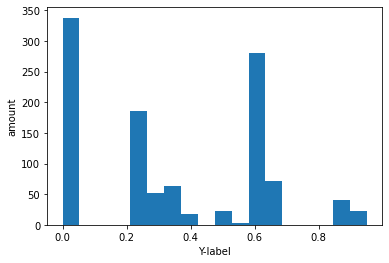

執行時間：1.401155 秒
Training_2


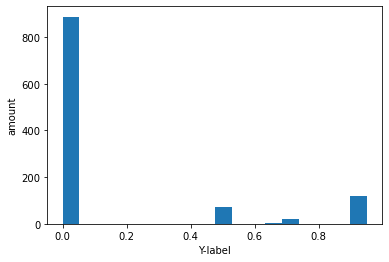

執行時間：1.384539 秒
Training_3


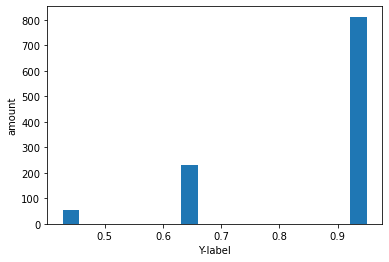

執行時間：1.417565 秒
Training_4


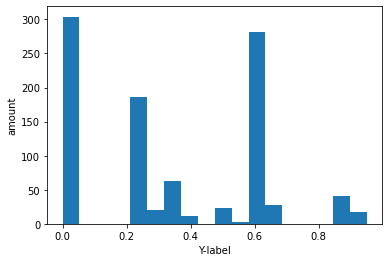

執行時間：1.267130 秒
Training_5


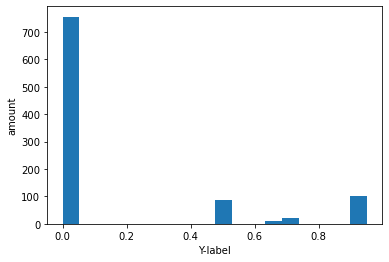

執行時間：1.238857 秒
Training_6


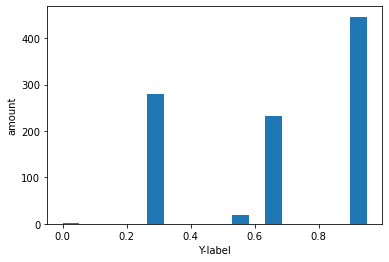

執行時間：1.291780 秒
Training_7


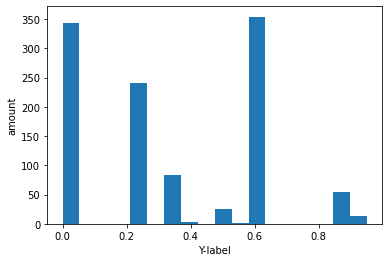

執行時間：1.434910 秒
Training_8


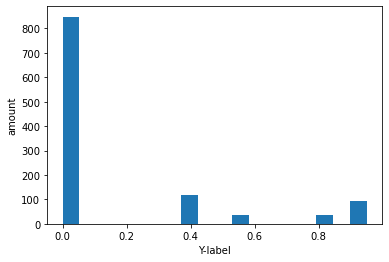

執行時間：1.401697 秒
Training_9


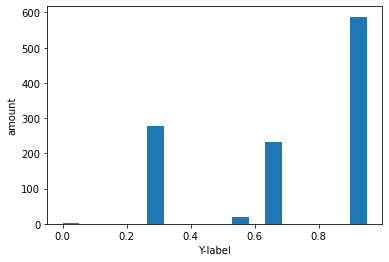

執行時間：1.465740 秒
Training_10


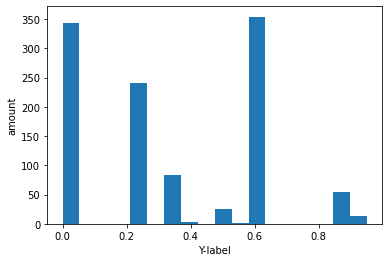

執行時間：1.482188 秒
Training_11


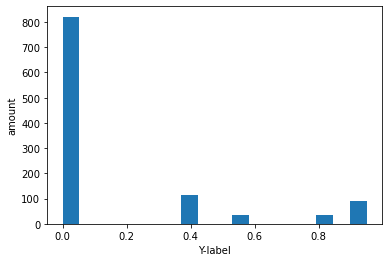

執行時間：1.384489 秒
Training_12


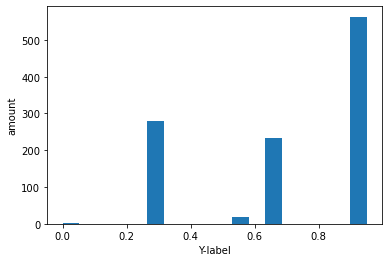

執行時間：1.409109 秒


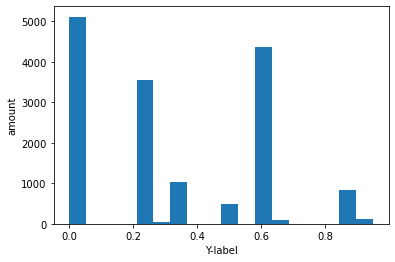

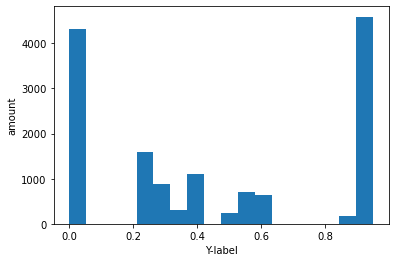

執行時間：52.234983 秒
DS A: 	0 ratio: 0.327 		1 ratio: 0.0
DS B: 	0 ratio: 0.292 		1 ratio: 0.02
DS 1: 	0 ratio: 0.236 		1 ratio: 0.231
DS 2: 	0 ratio: 0.62 		1 ratio: 0.231
DS 3: 	0 ratio: 0.0 		1 ratio: 0.231
DS 4: 	0 ratio: 0.24 		1 ratio: 0.231
DS 5: 	0 ratio: 0.596 		1 ratio: 0.231
DS 6: 	0 ratio: 0.001 		1 ratio: 0.231
DS 7: 	0 ratio: 0.238 		1 ratio: 0.228
DS 8: 	0 ratio: 0.582 		1 ratio: 0.226
DS 9: 	0 ratio: 0.001 		1 ratio: 0.228
DS 10: 	0 ratio: 0.238 		1 ratio: 0.228
DS 11: 	0 ratio: 0.577 		1 ratio: 0.232
DS 12: 	0 ratio: 0.001 		1 ratio: 0.232


In [20]:
''' --------------------------------------   5. Y值連續化  -------------------------------------- '''

%matplotlib inline
start = time.time()

K=pd.read_csv("Kinds.csv").iloc[:,1:]

S3_NewLevel(12)

DataSet_A=pd.read_csv('TrainingSet_0.csv').iloc[:,2:]
DataSet_B=pd.read_csv("TrainingSet_new.csv").iloc[:,2:]

df=NewLevel_AB(DataSet_A,K)
df.to_csv('DataSetting_A_reg.csv')
df=NewLevel_AB(DataSet_B,K)
df.to_csv('DataSetting_B_reg.csv')

end = time.time()
print("執行時間：%f 秒" % (end - start))

DS=pd.read_csv('DataSetting_A_reg.csv')
r_0=np.around(len(DS[DS.New_GB==0])/len(DS),decimals=3)
r_1=np.around(len(DS[DS.New_GB==1])/len(DS),decimals=3)
print('DS A:','\t0 ratio:',r_0,'\t\t1 ratio:',r_1)

DS=pd.read_csv('DataSetting_B_reg.csv')
r_0=np.around(len(DS[DS.New_GB==0])/len(DS),decimals=3)
r_1=np.around(len(DS[DS.New_GB==1])/len(DS),decimals=3)
print('DS B:','\t0 ratio:',r_0,'\t\t1 ratio:',r_1)
      
for i in range(1,13):
    DS=pd.read_csv('DataSetting_%s_reg.csv' %i)
    
    r_0=np.around(len(DS[DS.New_GB==0])/len(DS),decimals=3)
    r_1=np.around(len(DS[DS.New_GB==1])/len(DS),decimals=3)
    print('DS %s:'%i,'\t0 ratio:',r_0,'\t\t1 ratio:',r_1)

In [21]:
## Done
import winsound
winsound.Beep(400,3000)